<a href="https://colab.research.google.com/github/kjxeez/machine-learning/blob/main/Poly_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 2


### Дисциплина: Методы машинного обучения

##### Студент:  Акопян Изабелла Арменовна
##### Группа:   НБИ-01-20

## Москва 2023
***

### Вариант № 11

Лабораторная работа 2 – Вариант 11 

1. Набор данных: forest_fires 

2. Независимая переменная: features/FFMC 

3. Зависимая переменная: features/DMC 

4. Доп. признак: имеющий максимальную дисперсию 

5. Визуализация доп. признака – столбчатая диаграмма 

6. Показатель качества регрессии – MAE (mean absolute error) 

7. Степень полинома: 4 

8. Параметры глубокой нейронной сети: кол-во скрытых слоев – 4, кол-во нейронов в скрытом слое – 64, функция активации – сигмоида. 

В соответствии с индивидуальным заданием, указанным в записной книжке команды, выполните следующие работы:  

1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик). 

2. Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании.  
3. Постройте кривые обучения с зависимостью от количества эпох. 
4. Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок.  
5. Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.  
6. Визуализируйте этот признак в соответствии с индивидуальным заданием.  
7. Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков.  
8. Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика.  
9. Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве. 
10. Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду. 

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import tensorflow_datasets as tfds

Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик).



In [36]:
ds = tfds.load("forest_fires", split='train')
df = tfds.as_dataframe(ds)
df

,area,features/DC,features/DMC,features/FFMC,features/ISI,features/RH,features/X,features/Y,features/day,features/month,features/rain,features/temp,features/wind
0,10.820000,671.200012,181.100006,96.099998,14.300000,63.000000,7,5,1,7,6.400000,27.299999,4.900000
1,24.590000,750.500000,96.699997,90.500000,11.400000,55.000000,3,4,6,8,0.000000,20.600000,5.400000
2,0.170000,607.099976,131.699997,94.300003,22.700001,55.000000,6,5,1,7,0.000000,19.400000,4.000000
3,14.680000,671.200012,181.100006,96.099998,14.300000,27.000000,3,4,1,7,0.000000,32.299999,2.200000
4,88.489998,699.599976,133.300003,92.900002,9.200000,21.000000,4,4,2,8,0.000000,26.400000,4.500000
5,5.180000,714.299988,84.099998,89.599998,5.700000,35.000000,3,4,6,8,0.000000,23.799999,3.600000
6,9.960000,855.299988,290.000000,90.300003,7.400000,58.000000,2,5,4,8,0.000000,16.200001,3.600000
7,2.070000,596.299988,135.500000,95.000000,21.299999,28.000000,2,4,0,7,0.000000,30.600000,3.600000
8,5.970000,745.299988,99.000000,92.099998,9.600000,50.000000,7,4,4,8,0.000000,18.700001,2.200000
9,0.750000,503.600006,91.599998,92.199997,9.600000,70.000000,2,4,2,7,0.000000,20.700001,2.200000


Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании.

Независимая переменная: features/FFMC

Зависимая переменная: features/DMC

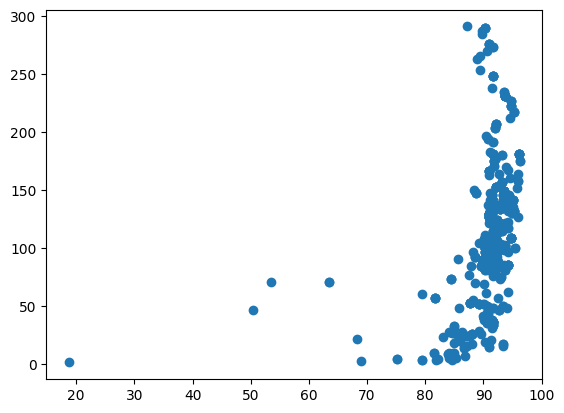

In [37]:

x = np.array(df['features/FFMC']) # вектор
y =  np.array(df['features/DMC'])
m=len(y)
X = x.reshape(-1, 1)  
plt.scatter(x, y);
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [38]:
X2 = np.hstack([X, X**2]) # соединение массивов по горизонтали
X2.shape


(517, 2)

In [39]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [65]:
x_train,x_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [81]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            517 non-null    float32
 1   features/DC     517 non-null    float32
 2   features/DMC    517 non-null    float32
 3   features/FFMC   517 non-null    float32
 4   features/ISI    517 non-null    float32
 5   features/RH     517 non-null    float32
 6   features/X      517 non-null    uint8  
 7   features/Y      517 non-null    uint8  
 8   features/day    517 non-null    int64  
 9   features/month  517 non-null    int64  
 10  features/rain   517 non-null    float32
 11  features/temp   517 non-null    float32
 12  features/wind   517 non-null    float32
dtypes: float32(9), int64(2), uint8(2)
memory usage: 27.4 KB


In [66]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4) 
X_train = poly.fit_transform(pd.DataFrame(x_train).values.reshape(-1, 1))
X_test = poly.transform(pd.DataFrame(x_test).values.reshape(-1, 1))
X_test

array([[ 1.0000000e+00, -1.0960897e+00,  1.2014127e+00, -1.3168561e+00,
         1.4433925e+00],
       [ 1.0000000e+00,  4.6297677e-02,  2.1434750e-03,  9.9237914e-05,
         4.5944848e-06],
       [ 1.0000000e+00,  8.2602113e-01,  6.8231094e-01,  5.6360328e-01,
         4.6554822e-01],
       [ 1.0000000e+00,  4.9962577e-01,  2.4962591e-01,  1.2471954e-01,
         6.2313095e-02],
       [ 1.0000000e+00,  6.4430527e-02,  4.1512931e-03,  2.6746999e-04,
         1.7233233e-05],
       [ 1.0000000e+00,  1.3696329e-01,  1.8758943e-02,  2.5692866e-03,
         3.5189796e-04],
       [ 1.0000000e+00,  5.1775861e-01,  2.6807398e-01,  1.3879761e-01,
         7.1863659e-02],
       [ 1.0000000e+00,  1.3696329e-01,  1.8758943e-02,  2.5692866e-03,
         3.5189796e-04],
       [ 1.0000000e+00,  4.4522583e-01,  1.9822605e-01,  8.8255361e-02,
         3.9293565e-02],
       [ 1.0000000e+00,  8.0788833e-01,  6.5268356e-01,  5.2729541e-01,
         4.2599580e-01],
       [ 1.0000000e+00, -3.163

In [95]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 100)
xgb_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [96]:
y_test_preds = xgb_reg.predict(X_test)

Постройте кривые обучения с зависимостью от количества эпох.



In [97]:

mae_test = mean_absolute_error(y_test, y_test_preds)
print('Test MAE:', mae_test)

Test MAE: 36.921425


In [99]:
params = {'objective': 'reg:squarederror', 
          'colsample_bytree': 0.3, 
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10, 
          'n_estimators': 100}

dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(dtrain=dtrain, 
                    params=params, 
                    nfold=5,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    metrics='mae',
                    as_pandas=True,
                    seed=123)

[15:05:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:05:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:05:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:05:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[15:05:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



Training MAE: 27.254818560262684
Validation MAE: 37.010459254248865


Text(0.5, 0, 'Эпохи обучения')

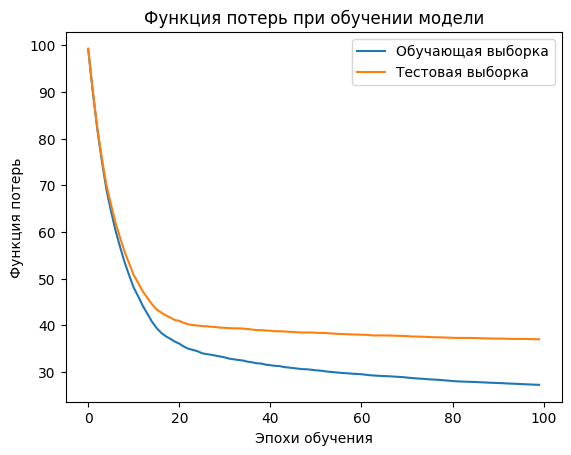

In [102]:
print('Training MAE:', cv_results['train-mae-mean'].iloc[-1])
print('Validation MAE:', cv_results['test-mae-mean'].iloc[-1])

cv_results[['train-mae-mean', 'test-mae-mean']].plot()
plt.ylabel('Функция потерь')
plt.legend(['Обучающая выборка', 'Тестовая выборка'], loc='upper right')
plt.title('Функция потерь при обучении модели')
plt.xlabel('Эпохи обучения')

Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок.

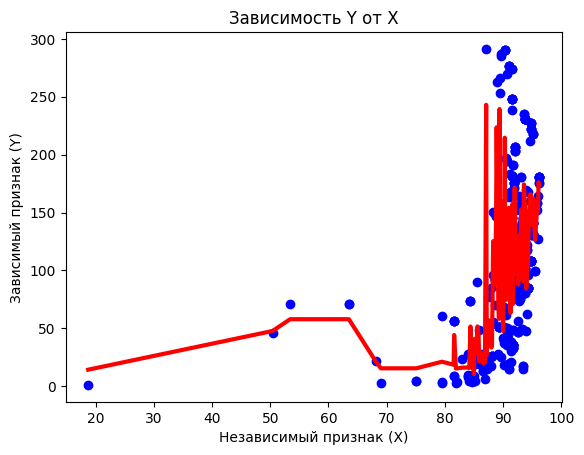

In [112]:
plt.scatter(x, y, color='blue')
X2 = np.hstack([X, X**2]) # соединение массивов по горизонтали
X2.shape
xgb_reg.fit(X2, y)
y_test_preds = xgb_reg.predict(X2)
# построение линии регрессии
plt.plot(np.sort(x), y_test_preds[np.argsort(x)], c='r', lw=3); 

# подписывание осей и рисунка
plt.title('Зависимость Y от X')
plt.xlabel('Независимый признак (X)')
plt.ylabel('Зависимый признак (Y)')
plt.show()

Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.

In [19]:
variances = df.var()
max_variance = variances.max()
print("Variances: ")
print(variances)
print("Max variance:", max_variance)

Variances: 
area               4052.063232
features/DC       61536.835938
features/DMC       4101.951660
features/FFMC        30.471624
features/ISI         20.788832
features/RH         266.259796
features/X            5.353568
features/Y            1.512655
features/day          4.297033
features/month        5.180131
features/rain         0.087592
features/temp        33.716896
features/wind         3.210019
dtype: float64
Max variance: 61536.8359375


признак с наибольшей дисперсией - features/DC       61536.835938

Визуализируйте этот признак в соответствии с индивидуальным заданием.

Визуализация доп. признака – столбчатая диаграмма

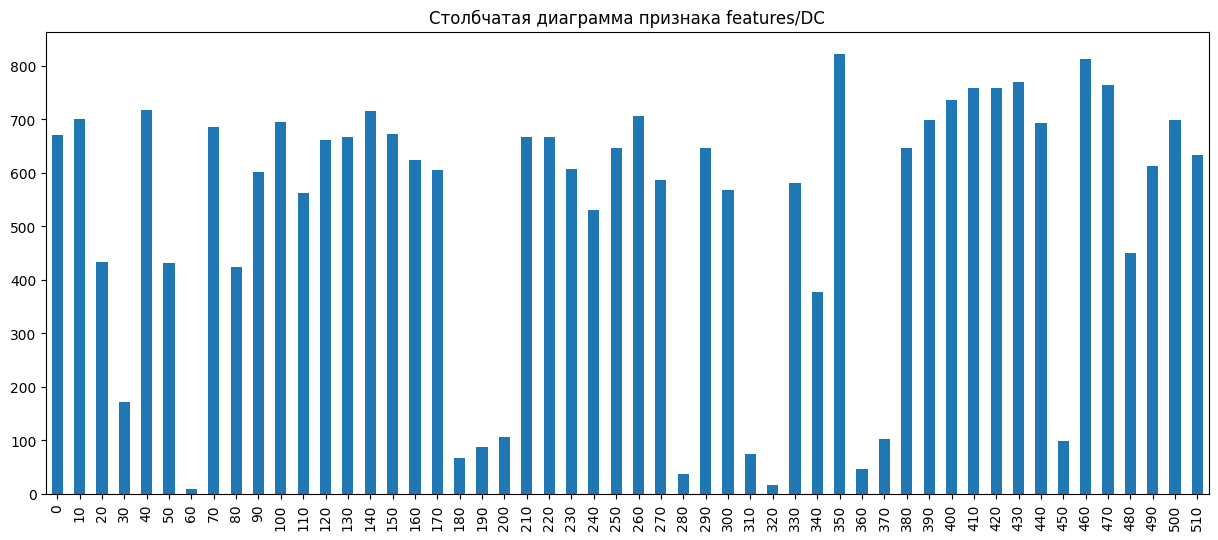

In [20]:
df[::10]['features/DC'].plot.bar(title='Столбчатая диаграмма признака features/DC', figsize=(15,6));

Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков.

In [21]:
X = df[['features/FFMC', 'features/DC']]
y = df['features/DMC']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((361, 2), (156, 2), (361,), (156,))

In [23]:
# Создание и адаптация нормализующего слоя
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(X_train)

Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика.

In [24]:
# кол-во скрытых слоев – 4, кол-во нейронов в скрытом слое – 64, функция активации – relu.
# Создание нейронной сети
model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(loss='mse', optimizer='adam')

# Обучение модели

train_score = []
test_score = []
history=[]
for i in range(11, 3428, 500):
    history.append(model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test)))
    y_train_predict = model.predict(X_train[:i])
    train_score.append(mean_absolute_error(y_train[:i], y_train_predict))
    y_test_predict = model.predict(X_test)
    test_score.append(mean_absolute_error(y_test, y_test_predict))
    print('-->', i, ' done')

Epoch 1/100
12/12 [==============================] - 6s 78ms/step - loss: 16123.3174 - val_loss: 16692.0586
Epoch 2/100
12/12 [==============================] - 0s 31ms/step - loss: 15870.0850 - val_loss: 16246.2803
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 15105.9570 - val_loss: 14876.5068
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 12908.6035 - val_loss: 11463.8281
Epoch 5/100
12/12 [==============================] - 0s 25ms/step - loss: 8407.9082 - val_loss: 5836.4355
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 3565.1926 - val_loss: 3573.8162
Epoch 7/100
12/12 [==============================] - 0s 28ms/step - loss: 2745.4094 - val_loss: 2555.3875
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 2387.2664 - val_loss: 2400.1526
Epoch 9/100
12/12 [==============================] - 0s 26ms/step - loss: 2340.7175 - val_loss: 2370.4055
Epoch 10/100
12/12 [==================

Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве.

313/313 [==============================] - 1s 2ms/step


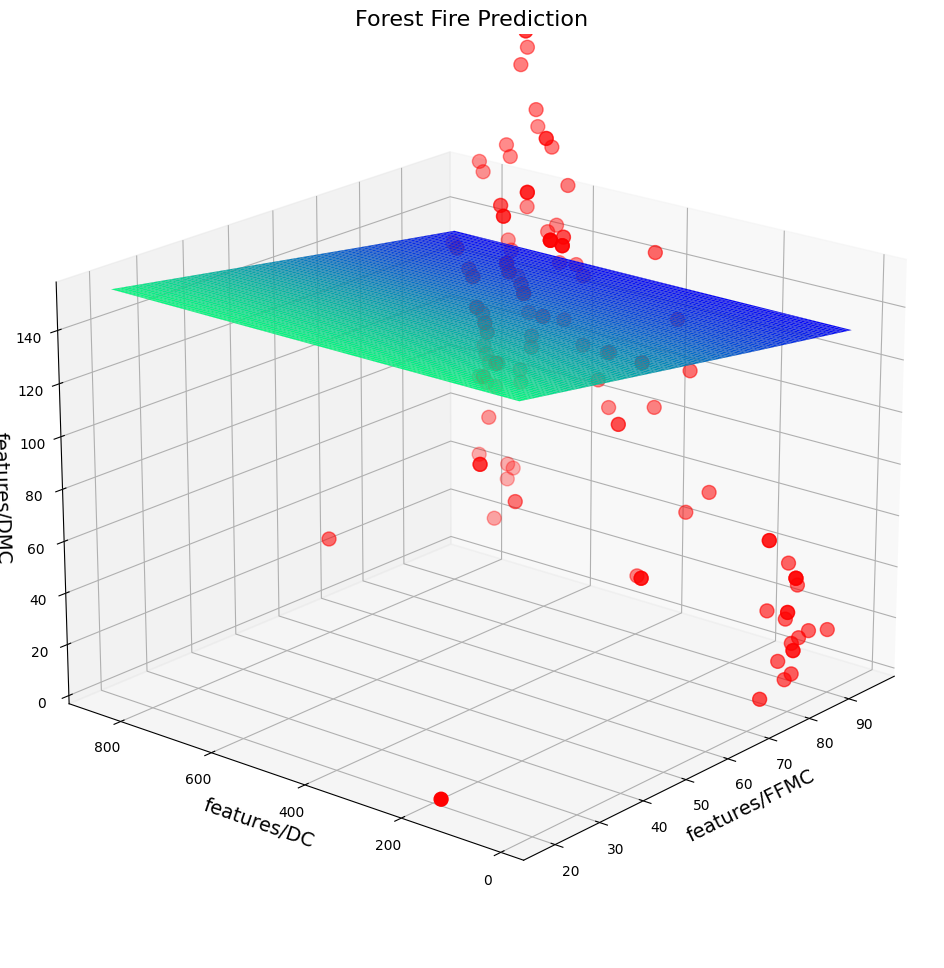

In [25]:
from matplotlib import cm
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Построение поверхности
x_mesh, y_mesh = np.meshgrid(np.linspace(X_test['features/FFMC'].min(), X_test['features/FFMC'].max(), 100), \
                             np.linspace(X_test['features/DC'].min(), X_test['features/DC'].max(), 100))
z_mesh = model.predict(normalizer(np.c_[x_mesh.ravel(), y_mesh.ravel()])).reshape(x_mesh.shape)

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, rstride=1, cstride=1, linewidth=0.05, cmap=cm.winter, antialiased=True,edgecolors='gray') 

# Построение точечного графика
xs = X_test['features/FFMC']
ys = X_test['features/DC']
zs = y_test
ax.scatter( xs, ys, zs, s=100, c='r' )

# Настройка осей и заголовка
ax.set_xlabel('features/FFMC', fontsize=14) 
ax.set_ylabel('features/DC', fontsize=14)
ax.set_zlabel('features/DMC', fontsize=14) 
ax.set_title('Forest Fire Prediction', fontsize=16)

# Настройка ограничений по оси z
ax.set_zlim(0., z_mesh.max())

# Настройка точки обзора
ax.view_init(elev = 20, azim = 220)

plt.show()

Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду.

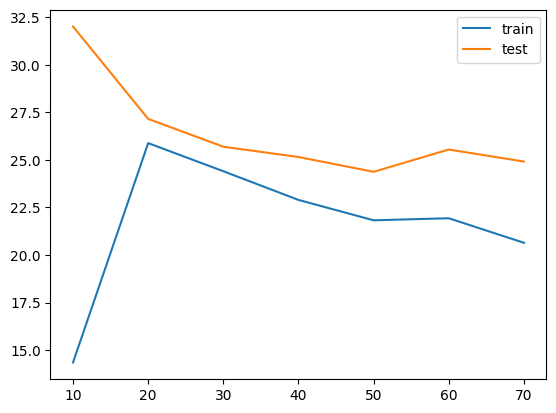

In [26]:
plt.plot([i for i in range(10, 71, 10)], 
         train_score, label="train")
plt.plot([i for i in range(10, 71, 10)], 
         test_score, label="test")
plt.legend()
